# Importando bibliotecas

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score


# Lendo dados 

In [2]:
df = pd.read_csv('../data/processed/sample_df_processed.csv')
df['speed'] = df['speed'].astype('str')
df['feed'] = df['feed'].astype('str')

In [3]:
df.dtypes

vibration_x    float64
vibration_y    float64
vibration_z    float64
machine         object
operation       object
description     object
speed           object
feed            object
duration         int64
result           int64
dtype: object

# Separando dados em treino e teste

In [4]:
X = df.drop(columns=["result"])  
y = df["result"]

# Separando o dataset em treino e teste mantendo a proporção das classes e com uma divisão de 70% para treino e 30% para teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Pre-processamento dos dados 

In [5]:
# DIVISÃO ENTRE COLUNAS CATEGORICAS E NUMERICAS
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

In [6]:
# NORMALIZAR COLUNAS NUMERICAS
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# CODIFICAR COLUNAS CATEGORICAS
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [7]:
# PRE-PROCESSAMENTO DOS DADOS 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Construindo modelo com dados brutos

## criando pipeline utilizando preprocessamento dos dados e utilizando a algoritmo de regressão logistica

In [8]:
# CRIANDO O PIPELINE COM OS DADOS PRE-PROCESSADOS E O CLASSIFICADOR
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

## Criando matriz de confusão

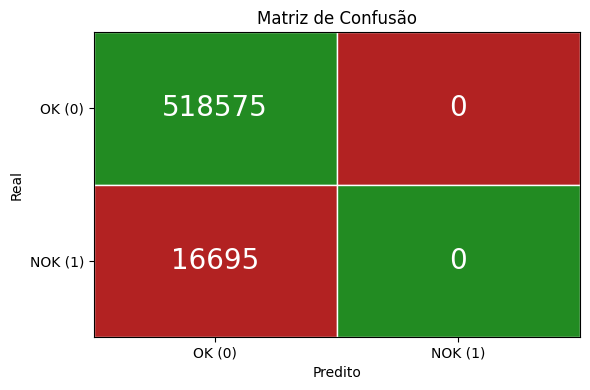

In [10]:
cm = confusion_matrix(y_test, y_pred)
labels = ["OK (0)", "NOK (1)"]

fig, ax = plt.subplots(figsize=(6, 4))

# Plotar manualmente com cores nos quadrantes
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]
        color = '#228B22' if i == j else '#B22222'
        ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, facecolor=color, edgecolor='white', linewidth=1))
        ax.text(j + 0.5, i + 0.5, str(value), ha='center', va='center', color='white', fontsize=20)

# Eixos e rótulos
ax.set_xticks([0.5, 1.5])
ax.set_xticklabels(labels)
ax.set_yticks([0.5, 1.5])
ax.set_yticklabels(labels)
ax.set_xlabel("Predito")
ax.set_ylabel("Real")
ax.set_title("Matriz de Confusão")

# Ajustes de grade
ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

1. Pelo gráfico observa-se para o resultado "Bom" o modelo acertou todos mas para valores "Ruim";
2. Provavelmente o desbalanceamento dos dados causa isso.

## Avaliando métricas

In [13]:
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.drop(columns=['support'])
report_df_formatted = report_df.head(3).map(lambda x: f"{x * 100:.2f}")
print(report_df_formatted)

         precision  recall f1-score
0            96.88  100.00    98.42
1             0.00    0.00     0.00
accuracy     96.88   96.88    96.88


Como esperando no relatório das métricas observamos:
1. Para resultado "Bom" o modelo tem boa precisão (96,9% de acerto), recall, f1-score;
2. Para o resultado "Ruim" o modelo não acertou nenhuma então tem precisão ruim (0% de acerto), recall;
3. Quando olhamos em termos gerais o modelo apresenta boas nos notas mas causadaos pelo inviesamento do dado que tem maior representatividade.

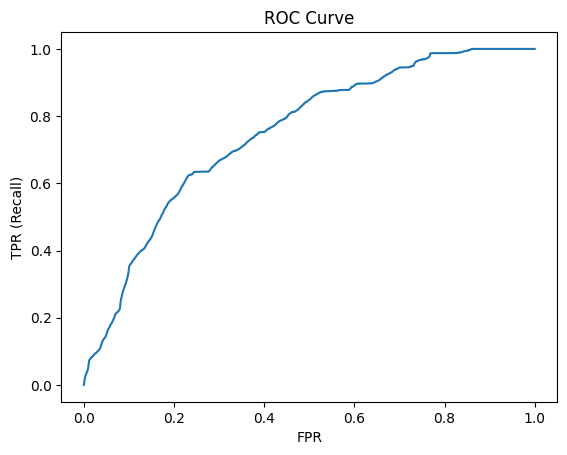

AUC: 0.75


In [12]:
y_proba = pipeline.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_proba)


fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR (Recall)")
plt.title("ROC Curve")
plt.show()
print(f"AUC: {auc:.2f}")	

Pela curva ROC observamos:
1. A curva não sobe rápido o que indica dificuldade em separar as classes.
2. O modelo não é muito discriminativos por isso necessita muitos falsos positivos para acertart os reais positivos.
3. o Valor de AUC é bom mas por causa do desbalanceamento.
   

## Otimizar resultado a partir da curva ROC

### Otimização F1-score

In [16]:
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_proba)
f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
optimal_threshold_f1 = thresholds_pr[np.argmax(f1)]

print(f"Threshold ideal (F1-score máximo): {optimal_threshold_f1:.4f}")

Threshold ideal (F1-score máximo): 0.0740


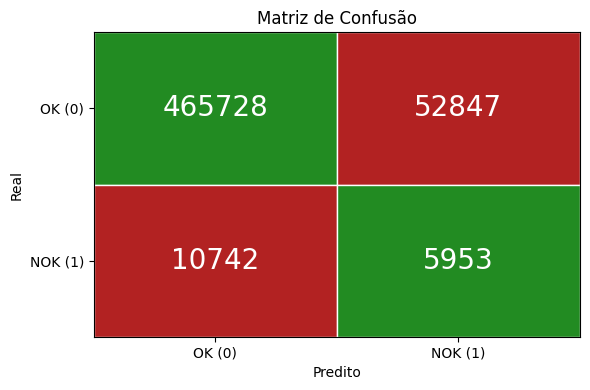

In [18]:
y_pred = (y_proba >= optimal_threshold_f1).astype(int)

cm = confusion_matrix(y_test, y_pred)
labels = ["OK (0)", "NOK (1)"]

fig, ax = plt.subplots(figsize=(6, 4))

# Plotar manualmente com cores nos quadrantes
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]
        color = '#228B22' if i == j else '#B22222'
        ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, facecolor=color, edgecolor='white', linewidth=1))
        ax.text(j + 0.5, i + 0.5, str(value), ha='center', va='center', color='white', fontsize=20)

# Eixos e rótulos
ax.set_xticks([0.5, 1.5])
ax.set_xticklabels(labels)
ax.set_yticks([0.5, 1.5])
ax.set_yticklabels(labels)
ax.set_xlabel("Predito")
ax.set_ylabel("Real")
ax.set_title("Matriz de Confusão")

# Ajustes de grade
ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [19]:
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.drop(columns=['support'])
report_df_formatted = report_df.head(3).map(lambda x: f"{x * 100:.2f}")
print(report_df_formatted)

         precision recall f1-score
0            97.75  89.81    93.61
1            10.12  35.66    15.77
accuracy     88.12  88.12    88.12


1. Para os casos OK observa-se uma leve melhora na precisão e queda no recall e f1-score;
2. Para os casos Nok há uma melhora nos 3 casos;
3. A acurácia geral tem uma queda.

### Otimização Youden

In [20]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
youden_index = tpr - fpr
optimal_threshold = thresholds[np.argmax(youden_index)]

print(f"Threshold ideal (Youden): {optimal_threshold:.4f}")


Threshold ideal (Youden): 0.0491


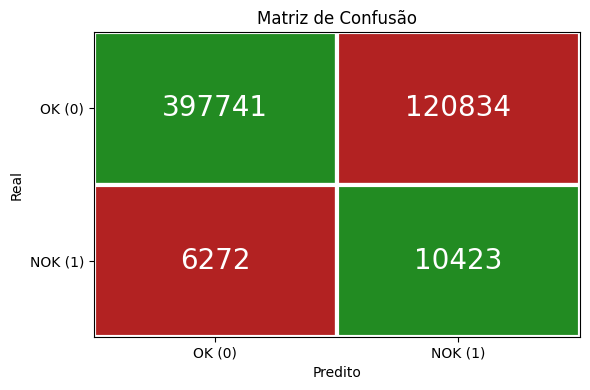

In [21]:
y_pred = (y_proba >= optimal_threshold).astype(int)

cm = confusion_matrix(y_test, y_pred)
labels = ["OK (0)", "NOK (1)"]

fig, ax = plt.subplots(figsize=(6, 4))

# Plotar manualmente com cores nos quadrantes
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]
        color = '#228B22' if i == j else '#B22222'
        ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, facecolor=color, edgecolor='white', linewidth=3))
        ax.text(j + 0.5, i + 0.5, str(value), ha='center', va='center', color='white', fontsize=20)

# Eixos e rótulos
ax.set_xticks([0.5, 1.5])
ax.set_xticklabels(labels)
ax.set_yticks([0.5, 1.5])
ax.set_yticklabels(labels)
ax.set_xlabel("Predito")
ax.set_ylabel("Real")
ax.set_title("Matriz de Confusão")

# Ajustes de grade
ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [22]:
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.drop(columns=['support'])
report_df_formatted = report_df.head(3).map(lambda x: f"{x * 100:.2f}")
print(report_df_formatted)

         precision recall f1-score
0            98.45  76.70    86.22
1             7.94  62.43    14.09
accuracy     76.25  76.25    76.25


1. Para os casos ok com essa otimização observa-se melhora na precisão mas queda no recall e f1-score;
2. Todas metricas para o caso NOK tiveram melhora;
3. A acurácia teve uma queda ainda maior que a otimização anterior.

## Resultados

1. O modelo é melhor que o aleatório mas ainda não é recomendado;
2. A tendência do modelo é sempre classificar como "bom" e assim errar pouco o que traz um vies muito ruim;
3. Proximos passos é testar balanceando os dados e verificando outros algoritmos.
4. Mesmo com otimizações o modelo com dados brutos não seria útil em produção.

# Construindo modelo com dados balanceados

## Criando pipeline utilizando preprocessamento dos dados e utilizando a algoritmo de regressão logistica

In [23]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000))
])


pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

## Criando matriz de confusão

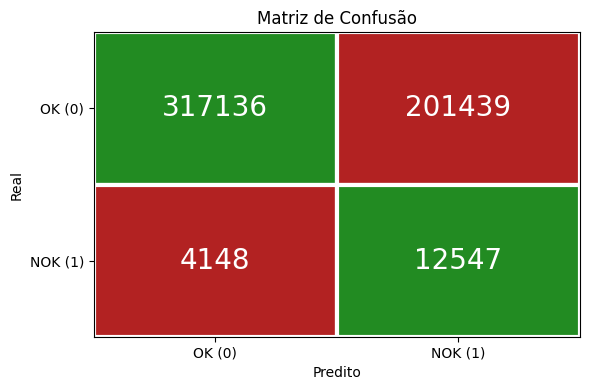

In [24]:
cm = confusion_matrix(y_test, y_pred)
labels = ["OK (0)", "NOK (1)"]

fig, ax = plt.subplots(figsize=(6, 4))

# Plotar manualmente com cores nos quadrantes
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]
        color = '#228B22' if i == j else '#B22222'
        ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, facecolor=color, edgecolor='white', linewidth=3))
        ax.text(j + 0.5, i + 0.5, str(value), ha='center', va='center', color='white', fontsize=20)

# Eixos e rótulos
ax.set_xticks([0.5, 1.5])
ax.set_xticklabels(labels)
ax.set_yticks([0.5, 1.5])
ax.set_yticklabels(labels)
ax.set_xlabel("Predito")
ax.set_ylabel("Real")
ax.set_title("Matriz de Confusão")

# Ajustes de grade
ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

Ao balancear os dados foi visto:
1. Houveram uma proporção boa entre TP e FN
2. A relação entre TN e FP melhorou mas valores ainda ruins o que faz indicar muitos resultados "Bom" como "Ruim"

## Avaliando métricas

In [25]:
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.drop(columns=['support'])
report_df_formatted = report_df.head(3).map(lambda x: f"{x * 100:.2f}")
print(report_df_formatted)

         precision recall f1-score
0            98.71  61.16    75.52
1             5.86  75.15    10.88
accuracy     61.59  61.59    61.59


Como esperando no relatório das métricas observamos:
1. Para resultado "Bom" o modelo tem boa precisão (98,7% de acerto) contudo o recall caiu (38,9% dos dados "Bom" estão classificados como "Ruim") e consequentemente f1-score também caiu;
2. Para o resultado "Ruim" o modelo começou a ter resultados com um recall bom (Detectou 75% das falhas) mas a precisão está muito baixa ainda ();
3. Quando olhamos em termos gerais o modelo apresenta boas nos notas mas causadaos pelo inviesamento do dado que tem maior representatividade.

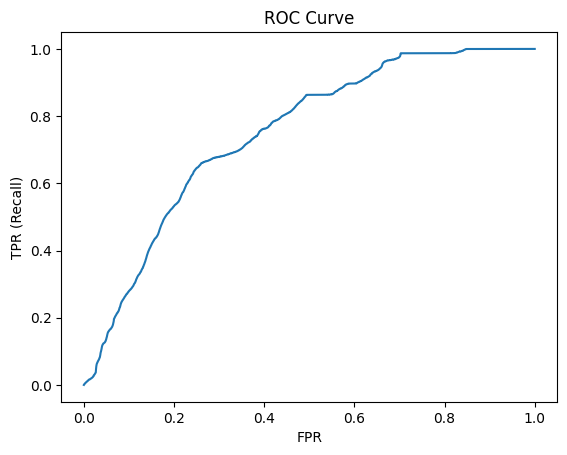

AUC: 0.75


In [26]:
y_proba = pipeline.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_proba)


fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR (Recall)")
plt.title("ROC Curve")
plt.show()
print(f"AUC: {auc:.2f}")


# Otimizar resultado a partir da curva ROC

## Otimização F1-score

In [27]:
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_proba)
f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
optimal_threshold_f1 = thresholds_pr[np.argmax(f1)]

print(f"Threshold ideal (F1-score máximo): {optimal_threshold_f1:.4f}")

Threshold ideal (F1-score máximo): 0.6608


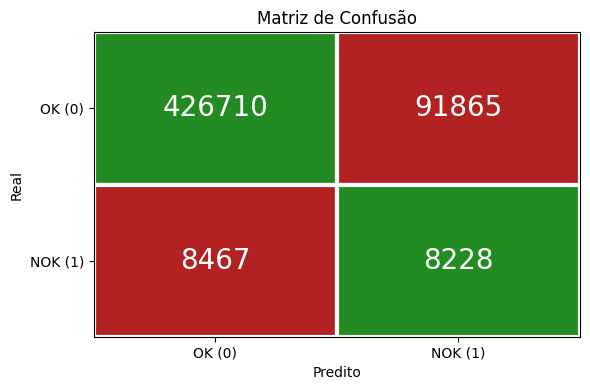

In [28]:
y_pred = (y_proba >= optimal_threshold_f1).astype(int)

cm = confusion_matrix(y_test, y_pred)
labels = ["OK (0)", "NOK (1)"]

fig, ax = plt.subplots(figsize=(6, 4))

# Plotar manualmente com cores nos quadrantes
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]
        color = '#228B22' if i == j else '#B22222'
        ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, facecolor=color, edgecolor='white', linewidth=3))
        ax.text(j + 0.5, i + 0.5, str(value), ha='center', va='center', color='white', fontsize=20)

# Eixos e rótulos
ax.set_xticks([0.5, 1.5])
ax.set_xticklabels(labels)
ax.set_yticks([0.5, 1.5])
ax.set_yticklabels(labels)
ax.set_xlabel("Predito")
ax.set_ylabel("Real")
ax.set_title("Matriz de Confusão")

# Ajustes de grade
ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [29]:
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.drop(columns=['support'])
report_df_formatted = report_df.head(3).map(lambda x: f"{x * 100:.2f}")
print(report_df_formatted)

         precision recall f1-score
0            98.05  82.29    89.48
1             8.22  49.28    14.09
accuracy     81.26  81.26    81.26


1. Para os casos OK houve uma queda bem leve na precisão mas um aumento considerável para recall e f1-score;
2. Para casos NOK a precisão aumentou levemente e o recall teve uma queda alta mas mesmo assim o f1-score aumentou;
3. A acurácia geral aumentou.

## Otimização Youden

In [30]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
youden_index = tpr - fpr
optimal_threshold = thresholds[np.argmax(youden_index)]

print(f"Threshold ideal (Youden): {optimal_threshold:.4f}")


Threshold ideal (Youden): 0.5912


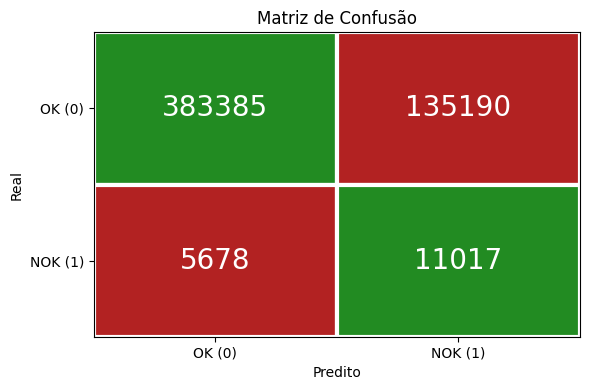

In [31]:
y_pred = (y_proba >= optimal_threshold).astype(int)

cm = confusion_matrix(y_test, y_pred)
labels = ["OK (0)", "NOK (1)"]

fig, ax = plt.subplots(figsize=(6, 4))

# Plotar manualmente com cores nos quadrantes
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]
        color = '#228B22' if i == j else '#B22222'
        ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, facecolor=color, edgecolor='white', linewidth=3))
        ax.text(j + 0.5, i + 0.5, str(value), ha='center', va='center', color='white', fontsize=20)

# Eixos e rótulos
ax.set_xticks([0.5, 1.5])
ax.set_xticklabels(labels)
ax.set_yticks([0.5, 1.5])
ax.set_yticklabels(labels)
ax.set_xlabel("Predito")
ax.set_ylabel("Real")
ax.set_title("Matriz de Confusão")

# Ajustes de grade
ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
ax.invert_yaxis()
plt.tight_layout()
plt.show()


In [32]:
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.drop(columns=['support'])
report_df_formatted = report_df.head(3).map(lambda x: f"{x * 100:.2f}")
print(report_df_formatted)

         precision recall f1-score
0            98.54  73.93    84.48
1             7.54  65.99    13.53
accuracy     73.68  73.68    73.68


1. Para os casos OK teve uma queda bem baixa mas com aumentos no recall e f1-score;
2. Para os casos NOK houve aumento na precisão e f1-score com queda no recall;
3. A acurácia geral aumentou mas com valor menor que a outra otimização testada.